<a href="https://colab.research.google.com/github/okana2ki/intro-to-AI/blob/main/team_allocaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Embeddingを用いたチーム編成

## 準備

### 日本語で利用可能なtext embeddingモデルの例

以下は、日本語で利用可能なtext embeddingモデルの例です（出典：NLP204チュートリアル, 松田寛）

日本語のモデル：

[SimCSE](https://aclanthology.org/2021.emnlp-main.552/), Gao+ (2021/04)
をベースにしたもの

> [Japanese SimCSE (BERT-base)](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) (2022/12)

> [Japanese Simple-SimCSE](https://github.com/hppRC/simple-simcse-ja?tab=readme-ov-file), Tsukagoshi+ (2023/10)

[ColBERT](https://arxiv.org/abs/2004.12832), Khattab+ (2020/04)
をベースにしたもの

> [JaColBERT](https://huggingface.co/bclavie/JaColBERT), Clavié (2023/12)

多言語モデルの例：

> [multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large), Wang+ (2024/02)


### Japanese SimCSE (BERT-base) モデルのロード

 このノートブックでは、text embeddingモデルとして、[Japanese SimCSE (BERT-base) ](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) を使用します。

 sentence-transformersを使って、このモデルを簡単に利用することができます。トークナイズのために、fugashiとunidic-liteが必要です。まず、下記のように、pipでsentence-transformersとfugashi, unidic-liteをインストールします。

In [ ]:
!pip install -U fugashi[unidic-lite]
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('pkshatech/simcse-ja-bert-base-clcmlp')

### モデルを利用した埋め込み (embedding) 作成例

In [ ]:
sentences = [
    "PKSHA Technologyは機械学習/深層学習技術に関わるアルゴリズムソリューションを展開している。",
    "この深層学習モデルはPKSHA Technologyによって学習され、公開された。",
    "広目天は、仏教における四天王の一尊であり、サンスクリット語の「種々の眼をした者」を名前の由来とする。",
]

embeddings = model.encode(sentences)
print(embeddings)

### 類似度はcosine類似度がお勧め

Japanese SimCSE (BERT-base) モデルは、学習時の損失関数にcosine類似度を使っているため、下流のタスクで**cosine類似度を類似度計算に使うことをおすすめ**します。とのとです。

## アンケート情報の読み込みと埋め込みへの変換

In [4]:
# prompt: グーグルドライブ上のCSVファイルを読み込む

from google.colab import drive
import pandas as pd

# Google Driveをマウント
drive.mount('/content/drive')

# CSVファイルのパスを指定
file_path = '/content/drive/MyDrive/genai4e/form_data.csv' # ここに自分のファイルパスを指定してください

# CSVファイルを読み込む
try:
  df = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
  exit()
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}. Check the file format.")
  exit()

#アンケートのテキストデータの列名を指定してください
#text_column = 'text' # 例: 'アンケート回答'
text_column = df.columns[2]  # 左から3列目を指定

# テキストデータをエンコード
if text_column in df.columns:
    embeddings = model.encode(df[text_column].tolist())
    df['embeddings'] = embeddings.tolist() # エンベディングを新しい列として追加
    print(df.head())
else:
  print(f"Error: Column '{text_column}' not found in the CSV file.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        タイムスタンプ                            ユーザー名  \
0  2025/04/16 11:18:46 午前 GMT+9  2124005@mail.miyasankei-u.ac.jp   
1  2025/04/16 11:19:59 午前 GMT+9  2123011@mail.miyasankei-u.ac.jp   
2  2025/04/16 11:21:42 午前 GMT+9  2124040@mail.miyasankei-u.ac.jp   
3  2025/04/16 11:21:57 午前 GMT+9  2124080@mail.miyasankei-u.ac.jp   
4  2025/04/16 11:21:59 午前 GMT+9  2124099@mail.miyasankei-u.ac.jp   

  ワークショップでやってみたいこと、関心があるテーマ、分野など、自由に書いて下さい。（記入された情報に基づき、AIによる自動チーム分けを実施する予定です；記入途中で改行すると、複数テーマが記入されたと解釈してチーム分けに使用する予定です）\n例：授業に遅れないように、朝、起こしてくれるアプリが作りたい\n例：マーケティングとAIを掛け合わせた感じのテーマを希望\n例：xxの部活をやっているんだけど、魅力的な新人勧誘を実施して、入部希望が倍増するようにしたい  \
0                     暇なときに話してくれる面白い友達が欲しいのでそいつを作りたい                                                                                                                                                                               

## コサイン類似度で階層的クラスタリング

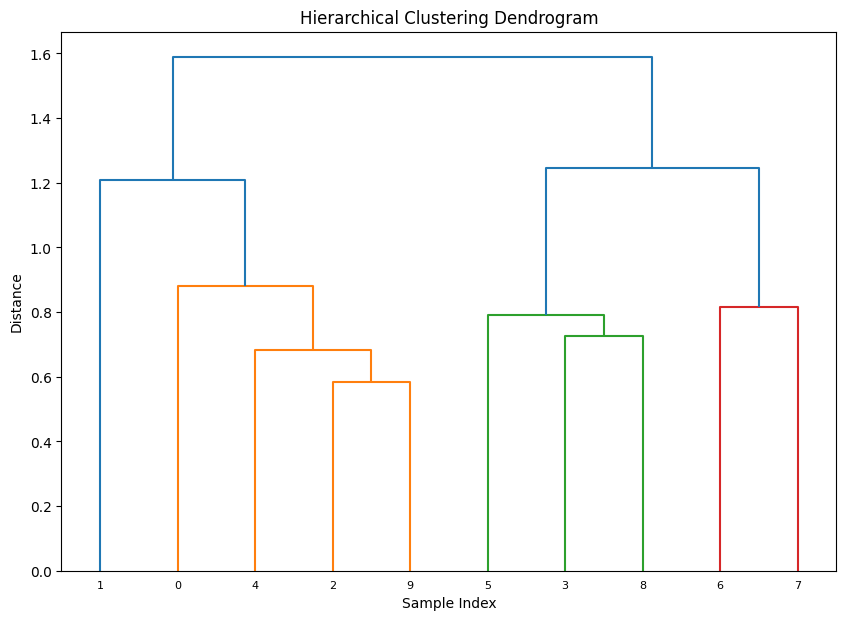

In [5]:
# prompt: コサイン類似度で階層的クラスタリングを行い、デンドログラムを表示して下さい。

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assuming 'embeddings' column exists in the DataFrame 'df'
if 'embeddings' in df.columns:
    # Convert embeddings to numpy array
    embeddings_array = np.array(df['embeddings'].tolist())

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_array)

    # Perform hierarchical clustering using cosine similarity
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
    linkage_matrix = linkage(distance_matrix, method='ward') # Use ward method for better results

    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=df.index.tolist(), orientation='top', leaf_font_size=8)  # Use df.index as labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
else:
    print("Error: 'embeddings' column not found in the DataFrame.")


In [6]:
# prompt: クラスタ数を指定すると、各クラスタに属するサンプルのサンプルインデクスとtext_culumnの内容を表示する

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

def show_cluster_members(linkage_matrix, df, n_clusters):
    # Perform clustering based on the specified number of clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Print the sample indices and text_column content for each cluster
    for i in range(1, n_clusters + 1):
        cluster_members = df[cluster_labels == i]
        print(f"Cluster {i}:")
        for index, row in cluster_members.iterrows():
          print(f"  Index: {index}, Text: {row[text_column]}")

# Example usage (assuming linkage_matrix and df are already defined)
# Replace 'n_clusters' with your desired number of clusters
n_clusters = 4  # Example: 3 clusters
show_cluster_members(linkage_matrix, df, n_clusters)


Cluster 1:
  Index: 0, Text: 暇なときに話してくれる面白い友達が欲しいのでそいつを作りたい
  Index: 2, Text: 悩み事があるときに解決策を提示してくれたり、暇つぶし相手になってくれそうなAI
  Index: 4, Text: 部活動のマネジメントをしてくれるようなBOTがほしい。（OOしてないけど大丈夫？OOしたほうがいいんじゃない？的なことを聞いてくれるやつ）
  Index: 9, Text: イベントを作る時の支援AIがほしい。お客さんが何人来てくれるかをイベント当日や月内の他のイベント、出演する有名人の集客力から推測したい。その後、赤字にならないようにチケット代やイベント日、収容人数の箱を教えてほしい。
Cluster 2:
  Index: 1, Text: 動物の言っていることや感情がわかるようになりたい。特に猫。
歌が上手くなりたい。
鍵の閉め忘れや大事な資料の置き忘れを注意喚起してほしい。
会計がもっとわかりやすくなってほしい。
Cluster 3:
  Index: 3, Text: 自分に合った系統の服を紹介してほしい バイトの給料を計算してくれるアプリがほしい
  Index: 5, Text: 夜ごはんのレシピを考えてくれるAIを作りたい
  Index: 8, Text: 宮崎のご飯屋や、イベントが全て載ってるアプリを作ってみたいです。（ご飯屋ならそのお店がどのくらい混んでいるのか、空いているのか知れたらいい）
Cluster 4:
  Index: 6, Text: 午後から雨が降りそうなときに教えてくれるアプリ
  Index: 7, Text: 観光マップのアプリを作りたい
